In [ ]:
%matplotlib inline

## Configuring

To make the sometimes painful process of keeping track of global parameters and input/output file paths easier, we usually like to set these through EUGENE's `settings` up front. This will control the default directories for things like:

- Data downloads with `seqdatasets`
- Model configuration files (i.e. EUGENe will know where to look for these files without you having to specify the full path every time)
- Model logs, checkpoints, and predictions
- Figures and plots

These small quality of life features can go a long way to preserve your sanity!

In [1]:
!pip install 'eugene-tools'

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

if not os.path.exists("/content/drive/MyDrive/EUGENe"):
  os.makedirs("/content/drive/MyDrive/EUGENe")

os.chdir("/content/drive/MyDrive/EUGENe")
cwd = os.getcwd()
cwd

Mounted at /content/drive


'/content/drive/MyDrive/EUGENe'

In [4]:
# Configure EUGENe directories, if you do not set these, EUGENe will use the default directories
from eugene import settings
settings.config_dir = "./tutorial_configs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "./tutorial_dataset" # Directory where EUGENe will download datasets to
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to
settings.figure_dir = "./tutorial_figures" # Directory to specify to EUGENe to save figures to

## Dataloading
For this tutorial, we will reproduce the prediction of promoter activity featured in [Jores et al., 2021](https://www.nature.com/articles/s41477-021-00932-y) that uses DNA sequences as input to predict [STARR-seq activity](https://en.wikipedia.org/wiki/STARR-seq). We first need to load this dataset. If the dataset is a "EUGENe benchmarking dataset", it can be loaded in through the `SeqDatasets` [subpackage](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#seqdatasets-access-to-common-datasets). Let's load the package first

In [5]:
import seqdatasets

We can next use the get_dataset_info() function to get information about the datasets available as "EUGENe benchmarking datasets".




In [6]:
# Check the dataset
seqdatasets.get_dataset_info()

,n_seqs,n_targets,metadata,url,description,author
dataset_name,,,,,,
random1000,1000,1,10 randomly generated binary labels (label_{0-...,https://github.com/cartercompbio/EUGENe/tree/m...,A randomly generated set of 1000 sequences wit...,Adam Klie (aklie@eng.ucsd.edu)
ray13,241357,244,"probe set (Probe_Set), bidning intensity value...",http://hugheslab.ccbr.utoronto.ca/supplementar...,This dataset represents an in vitro RNA bindin...,Hayden Stites (haydencooperstites@gmail.com)
farley15,163708,2,"barcode (Barcode), RPMs from each biological r...",https://zenodo.org/record/6863861#.YuG15uxKg-Q,This dataset represents SEL-seq data of C. int...,Adam Klie (aklie@eng.ucsd.edu)
deBoer20,100000000+,1,Variable depending on chosen file,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...,Gigantic parallel reporter assay data from ~10...,Adam Klie (aklie@eng.ucsd.edu)
jores21,147966,1,"set (set), species (sp), gene promoter came fr...",https://raw.githubusercontent.com/tobjores/Syn...,"This datast includes activity scores for 79,83...",Adam Klie (aklie@eng.ucsd.edu)
deAlmeida22,484052,4,Normalized enrichment scores for developmental...,https://zenodo.org/record/5502060/,This dataset includes UMI-STARR-seq data from ...,Adam Klie (aklie@eng.ucsd.edu)


In [7]:
# Download the dataset to the dataset dir. We are using the promoters assayed in leaf promoters here
sdata = seqdatasets.jores21(dataset="leaf")
sdata

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.
Zarr file found. Opening zarr file.


<xarray.Dataset>
Dimensions:     (_sequence: 72158, _length: 170)
Dimensions without coordinates: _sequence, _length
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>

## Data Visualization
Data visualization is a key part of the EUGENe workflow. We can use the `plot` module to visualize aspects of our data such as the distribution of targets.

In [8]:
from eugene import plot as pl

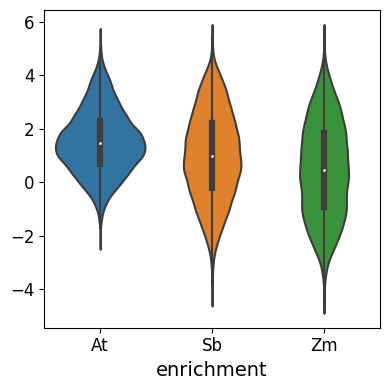

In [9]:
# Plot the distribution of targets across the different species the promoters were derived from
pl.violinplot(sdata, vars=["enrichment"], groupby="sp", figsize=(4, 4))

## Preprocessing
Now that we have our data loaded in, we can preprocess it using EUGENe's `preprocess` module. This module wraps functionality from the `SeqPro` [subpackage](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#sequence-manipulation-is-handled-efficiently-by-seqpro) and includes several functions for common sequence preprocessing tasks.

### Sequence preprocessing

In [10]:
from eugene import preprocess as pp

In [11]:
# One hot encode all the sequences in the sdata using the wrapper function
pp.ohe_seqs_sdata(sdata, alphabet="DNA")

In [13]:
# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata)

### Dataset preprocessing

In [14]:
# Split into train and test sets
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())

In [15]:
# Split the training set into training and validation
pp.train_test_random_split(sdata_train, dim="_sequence", train_var="train_val", test_size=0.2)

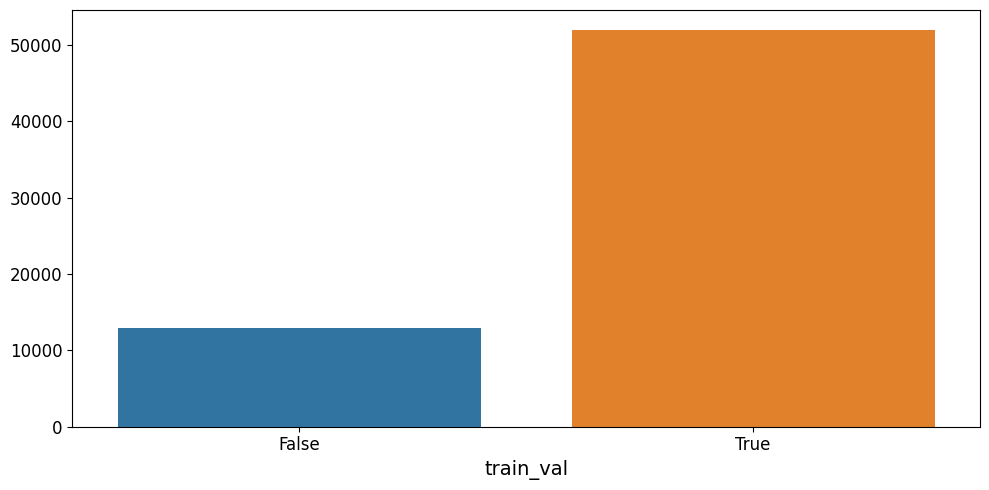

In [16]:
# Check the split with a count plot
pl.countplot(sdata_train, vars="train_val", orient="h")

## Training

### Instantiation and initialization

In [69]:
from eugene import models

In [70]:
# TODO: Change to your repository with updated configuration
!mkdir -p $cwd/tutorial_configs
#!wget https://raw.githubusercontent.com/adamklie/EUGENe_paper/revision/configs/jores21/hybrid.yaml -O $cwd/tutorial_configs/hybrid.yaml
!wget https://raw.githubusercontent.com/hannahcarrolll/BME5990_Miniproject_1/main/hannah.yaml -O $cwd/tutorial_configs/hannah.yaml

--2024-10-03 01:05:21--  https://raw.githubusercontent.com/hannahcarrolll/BME5990_Miniproject_1/main/hannah.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 646 [text/plain]
Saving to: ‘/content/drive/MyDrive/EUGENe/tutorial_configs/hannah.yaml’

/content/drive/MyDr 100%[===================>]     646  --.-KB/s    in 0s      

2024-10-03 01:05:21 (33.9 MB/s) - ‘/content/drive/MyDrive/EUGENe/tutorial_configs/hannah.yaml’ saved [646/646]



## MiniProject 1 Modifications

From the original cnn.yaml module, I modified the convolutional channels from [13,13,13] to [10,10,10]. By doing this, I reduced the number of channels, limiting the amount of feature extraction. This means that the model may not capture all relavant features. By doing this I also reduce the computational load making it easier to train the model.

I added this section of code below to ensure that the model I am using 'hannah.yaml' is being imported correctly.

In [74]:
with open("tutorial_configs/hannah.yaml") as f:
    print(f.read())

module: SequenceModule
model:
  model_name: CNNalaJores21
  arch_name: CNN
  arch:
    input_len: 170
    output_dim: 1
    conv_kwargs:
      input_channels: 4
      conv_channels: [256, 256, 256]
      conv_kernels: [10, 10, 10]
      conv_strides: [1, 1, 1]
      pool_kernels: [2, 2, 2]
      pool_strides: [2, 2, 2]
      dropout_rates: 0.3
      batchnorm: True
      activations: relu
    dense_kwargs:
      hidden_dims: [64]
      dropout_rates: 0.2
      batchnorm: True
task: regression
loss_fxn: mse
optimizer: adam
optimizer_lr: 0.001
scheduler: reduce_lr_on_plateau
scheduler_monitor: val_loss_epoch
scheduler_kwargs:
  patience: 2



In [71]:
model = models.load_config("hannah.yaml")

In [72]:
# Print out a summary of the model
model.summary()

Model: CNN
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | arch         | CNN     | 1.5 M  | train
1 | train_metric | R2Score | 0      | train
2 | val_metric   | R2Score | 0      | train
3 | test_metric  | R2Score | 0      | train
-------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.146     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode

In [76]:
# Initialize the weights
models.init_weights(model)

In [77]:
# Remove old checkpoints
import shutil
shutil.rmtree(os.path.join(settings.logging_dir, "hannah", "tutorial_model", "checkpoints"), ignore_errors=True)

### Model fitting

In [78]:
from eugene import train

In [79]:
train.fit_sequence_module(
    model=model,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=25,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="hannah",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | arch         | CNN     | 1.5 M  | train
1 | train_m

No seed set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_

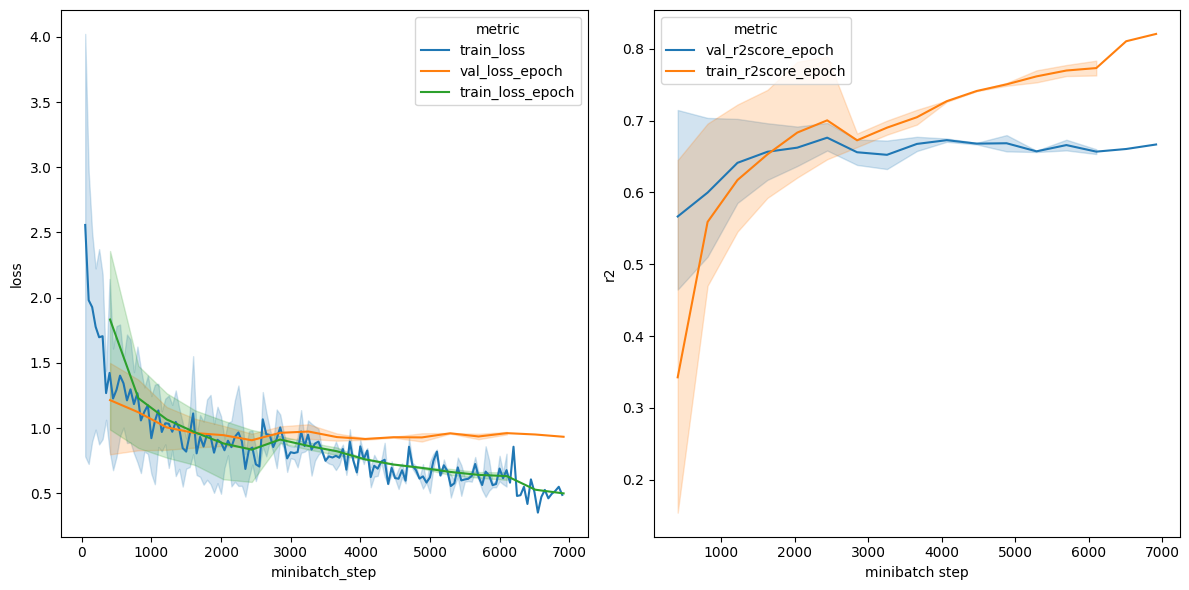

In [80]:
# Plot a loss curve and an r2 curve as a metric
pl.training_summary(os.path.join(settings.logging_dir, "hannah", "tutorial_model"), metric="r2")

## Evaluation

In [81]:
from eugene import evaluate

In [82]:
# We will use the glob Python library to help us find the path to our model
import glob

## Additions

I added this code below to ensure that with my reduced convolutional channels, new checkpoints are being created.

In [83]:
new_checkpoints = glob.glob(os.path.join(settings.logging_dir, "hannah", "tutorial_model", "checkpoints", "*"))
print(new_checkpoints)  # Check if new checkpoints are created

['/content/drive/MyDrive/EUGENe/tutorial_logs/hannah/tutorial_model/checkpoints/epoch=11-step=4884.ckpt']


In [84]:
# Load the best model from the new checkpoint
if new_checkpoints:
    best_model = models.SequenceModule.load_from_checkpoint(new_checkpoints[0], arch=model.arch)
else:
    print("No checkpoints found. Ensure that the model was trained successfully.")


In [85]:
# Use this best model to predict on the held-out data. This will store predictions in
evaluate.predictions_sequence_module(
    best_model,
    sdata=sdata_test,
    seq_var="ohe_seq",
    target_vars="enrichment",
    batch_size=2048,
    in_memory=True,
    name="hybrid",
    version="tutorial_model",
    file_label="test",
    prefix=f"tutorial_model_",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading ohe_seq and ['enrichment'] into memory


Predicting: |          | 0/? [00:00<?, ?it/s]

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.5129534891011402 0.6783755782273359 0.702336908146057
Sb 0.6438651262520473 0.9669125579720426 0.8198628395019162
Zm 0.7107014759608223 0.8808696342381749 0.8469168502280944


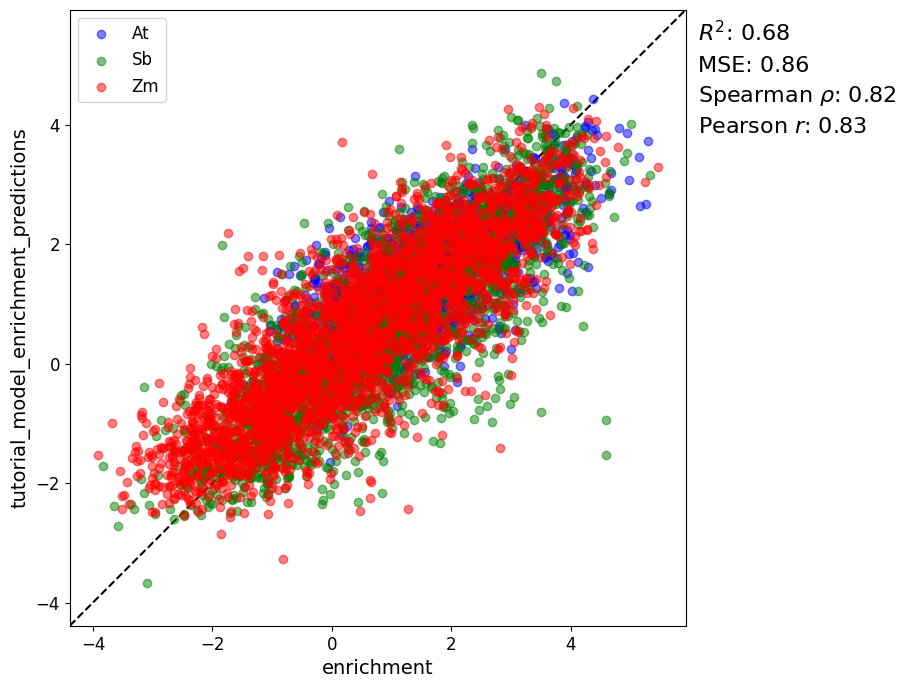

In [86]:
pl.performance_scatter(
    sdata_test,
    target_vars="enrichment",
    prediction_vars="tutorial_model_enrichment_predictions",
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8)
)

## Interpretation

In [87]:
from eugene import interpret

### Filter interpretation

In [88]:
interpret.generate_pfms_sdata(
    best_model,
    sdata_test,
    seq_var="ohe_seq",
    layer_name="arch.conv1d_tower.layers.1",
    kernel_size=13,
    num_filters=256,
    num_seqlets=100,
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Getting activations on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

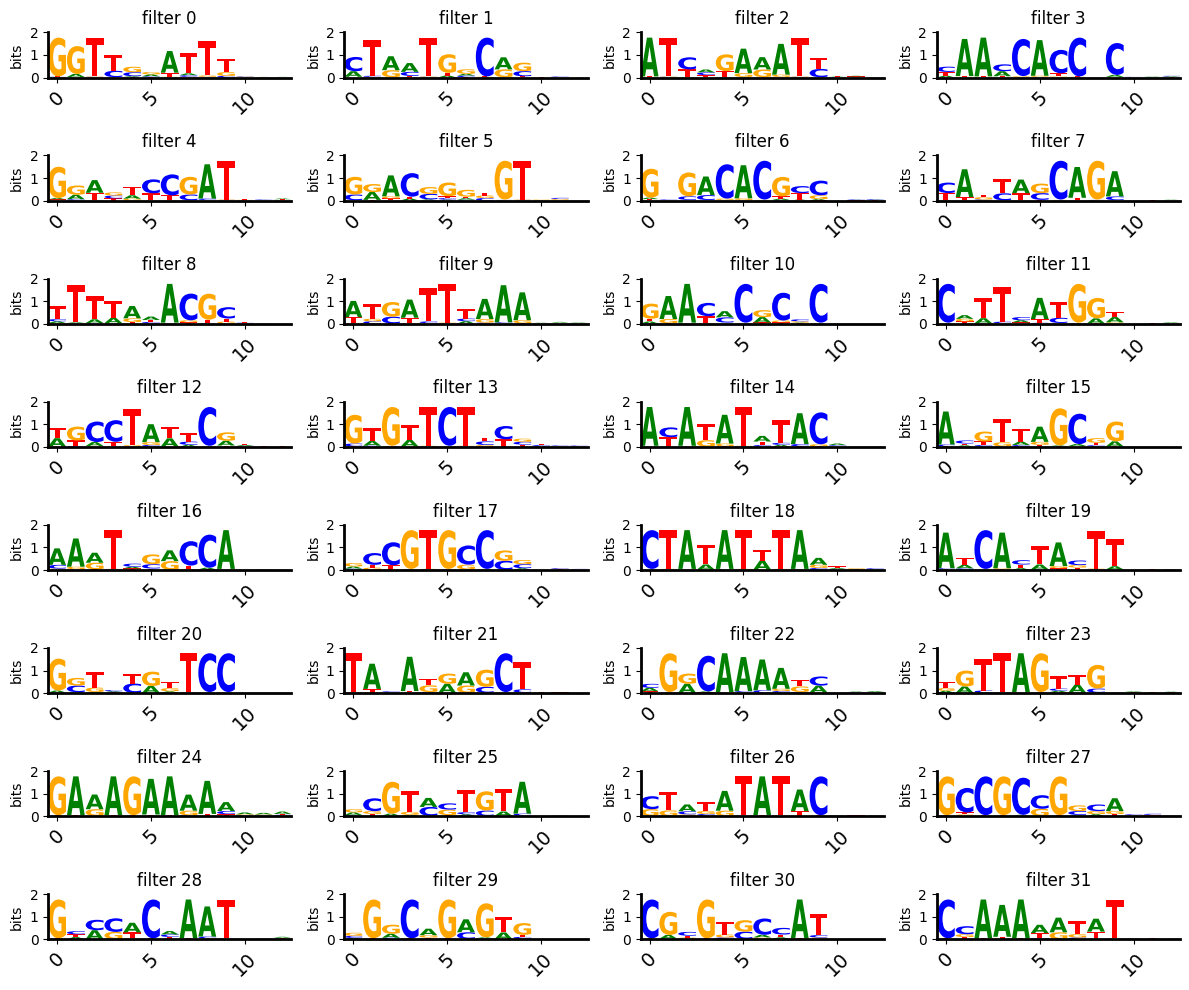

In [89]:
# We can visualize these PFMs as PWM logos
pl.multifilter_viz(
    sdata_test,
    filter_nums=range(0, 32),
    pfms_var="arch.conv1d_tower.layers.1_pfms",
    num_rows=8,
    num_cols=4,
    titles=[f"filter {i}" for i in range(0, 32)],
)

In [90]:
interpret.filters_to_meme_sdata(
    sdata_test,
    filters_var="arch.conv1d_tower.layers.1_pfms",
    axis_order=("_arch.conv1d_tower.layers.1_256_filters", "_ohe", "_arch.conv1d_tower.layers.1_13_kernel_size"),
    output_dir=os.path.join(settings.output_dir),
    filename="tutorial_model_best_model_filters.meme"
)

Output directory already exists: /content/drive/MyDrive/EUGENe/tutorial_output
Saved pfm in MEME format as: /content/drive/MyDrive/EUGENe/tutorial_output/tutorial_model_best_model_filters.meme


### Attribution analysis

In [91]:
interpret.attribute_sdata(
    best_model,
    sdata_test,
    method="DeepLift",
    batch_size=128,
    reference_type="zero",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Computing saliency on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqexplainer/attributions/_attributions.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_ = torch.tensor(inputs_, dtype=torch.float32).requires_grad_(True).to(device)
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:467: UserWarning: An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  warnings.warn

Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

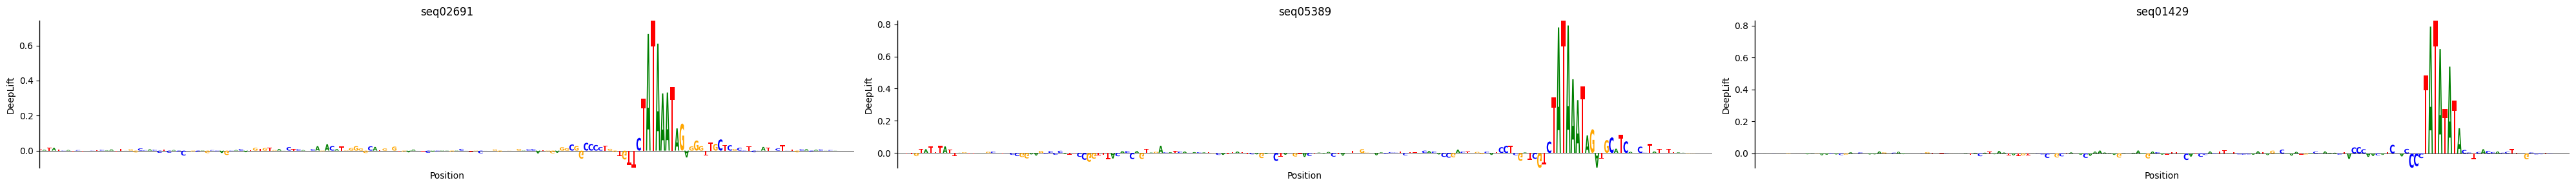

In [92]:
# Grab the top3 in terms of predictions to plot tracks for
top3 = sdata_test["tutorial_model_enrichment_predictions"].to_series().sort_values(ascending=False).iloc[:3].index
ids = sdata_test["id"].values[top3]
pl.multiseq_track(
    sdata_test,
    seq_ids=ids,
    attrs_vars = "DeepLift_attrs",
    ylabs="DeepLift",
    height=3,
    width=40,
)

### Global importance analysis (GIA)

In [93]:
# Import the packages
import seqpro as sp
import xarray as xr

In [94]:
# Create an SeqData object so its compatible with the function
random_ohe_seq = sp.ohe(sp.random_seqs((5, 170), sp.alphabets.DNA), sp.alphabets.DNA).swapaxes(1, 2)
sdata_random = xr.Dataset({"ohe_seq": (("_sequence", "_ohe", "length"), random_ohe_seq)})
pp.make_unique_ids_sdata(sdata_random, id_var="name")

In [95]:
# Let's get our background predictions
sdata_random["background_predictions"] = best_model.predict(sdata_random["ohe_seq"].values).squeeze()

Predicting on batches: 0it [00:00, ?it/s]

In [96]:
import motifdata as md

In [99]:
# TODO: The motif can be downlaoded from https://github.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/blob/main/data/misc
!wget https://raw.githubusercontent.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/main/data/misc/CPEs.meme -O $cwd/tutorial_dataset/CPEs.meme

--2024-10-03 01:43:42--  https://raw.githubusercontent.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/main/data/misc/CPEs.meme
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2913 (2.8K) [text/plain]
Saving to: ‘/content/drive/MyDrive/EUGENe/tutorial_dataset/CPEs.meme’

/content/drive/MyDr 100%[===================>]   2.84K  --.-KB/s    in 0.001s  

2024-10-03 01:43:42 (2.84 MB/s) - ‘/content/drive/MyDrive/EUGENe/tutorial_dataset/CPEs.meme’ saved [2913/2913]



In [100]:
# We can load it and pull out the PFM and other info about the motif
meme = md.read_meme(os.path.join(settings.dataset_dir, "CPEs.meme"))
motif = meme.motifs["TATA"]
feat_name = motif.name
pfm = motif.pfm
consensus = motif.consensus
consensus_ohe = sp.ohe(consensus, alphabet=sp.alphabets.DNA)
feat_name, pfm, consensus

('TATA',
 array([[0.1275, 0.3765, 0.1195, 0.3765],
        [0.1575, 0.3985, 0.199 , 0.2455],
        [0.249 , 0.303 , 0.197 , 0.251 ],
        [0.1235, 0.655 , 0.0755, 0.1455],
        [0.01  , 0.002 , 0.002 , 0.986 ],
        [0.968 , 0.    , 0.    , 0.032 ],
        [0.002 , 0.014 , 0.006 , 0.978 ],
        [0.992 , 0.    , 0.002 , 0.006 ],
        [0.653 , 0.012 , 0.002 , 0.333 ],
        [0.974 , 0.    , 0.008 , 0.018 ],
        [0.341 , 0.028 , 0.036 , 0.5955],
        [0.6955, 0.0815, 0.1195, 0.1035],
        [0.1255, 0.432 , 0.3165, 0.1255],
        [0.291 , 0.418 , 0.175 , 0.1155],
        [0.263 , 0.3445, 0.1755, 0.2175],
        [0.307 , 0.3085, 0.2365, 0.1475]]),
 'CCCCTATAAATACCCC')

In [101]:
# This is the EUGENe function that does exactly that!
interpret.positional_gia_sdata(
    model=best_model,
    sdata=sdata_random,
    feature=consensus_ohe,
    id_var="name",
    store_var=f"slide_{feat_name}",
    encoding="onehot"
)

Implanting feature in all seqs of sdata:   0%|          | 0/5 [00:00<?, ?it/s]

## Additions

Added import inspect because the original plot code below wasn't working, edited the plot code from there using 'keys' instead of vars or features.

In [106]:
import inspect
print(inspect.signature(pl.positional_gia_plot))

(sdata, keys: list, id_var: str = 'id', xlab: str = 'Position', ylab: str = 'Predicted Score', ylim: Optional[tuple] = None, save: Optional[os.PathLike] = None, return_axes: bool = False)


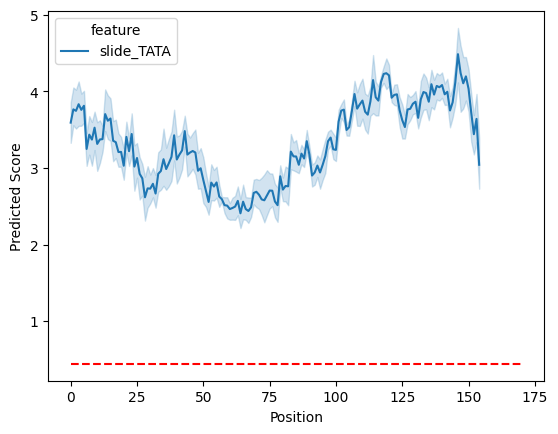

In [107]:
# Plot the positional GIA using the correct parameter name
ax = pl.positional_gia_plot(
    sdata_random,
    keys=[f"slide_{feat_name}"],  # Use `keys` instead of `vars` or `features`
    id_var="name",
    return_axes=True
)

# Add the horizontal line for background predictions
ax.hlines(sdata_random["background_predictions"].mean(), 0, 170, linestyle="--", color="red")

### Sequence generation

In [108]:
# Evolve this sequence for ten rounds
interpret.evolve_seqs_sdata(model=best_model, sdata=sdata_random, rounds=10)

Evolving seqs:   0%|          | 0/5 [00:00<?, ?it/s]

In [109]:
# Get all the vars that start with "evolved"
evolved_vars = ["original_score"] + [var for var in sdata_random.data_vars if var.startswith("evolved") and var.endswith("score")]